In this project, we are going to learn:

1 - Overview of how the brin works

2 - How to build simplified models of complex biological systems

3 - Integrate concepts covered in previous lectures

Broadly speaking, we can approach neuroscience from one of two perspectives: **Empirical Neuroscience** (Empirically measure brain activity) and **Computational Neuroscience** (Also known as Theoretical Neuroscience where we use computation simulations, a series of math equations we use to characterize the activity of neurons).

Computational Neuroscience is a very large field studying brain from the level of single neuron to the whole organ. It is broadly divided into four levels:

a) Level I: Detailed Compartmental Models

b) Level II: Reduced Compartmental Models

c) Level III: Single Comparmtnetal Models

d) Level IV: Cascade Models

e) Level V: Black-Box Models

In this project we will work with Izhikevich Model.

## Simulate 1 Brain Cell

The two key equations that govern the neuron's behavior are defined as:

$v \leftarrow v + 0.04v^2 + 5v +140 - u + I$

$u \leftarrow u + a(bv - u)$

if $v \geq 30: v = c, u = u+d$

a = 0.02, b = 0.2, c = -50, d = 2, v = -65, u = bv

We set up a for loop that goes over time points with a certain timepoint, and the voltage value will be updated with every instance of the loop.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Initial Parameters
a = 0.02 
b = 0.2 
c = -50 
d = 2 
v = -65
u = b*v

In [3]:
# Initialize the 
simulation_time = 1000 # time in ms
memvolt = np.zeros(simulation_time)
Iall = np.zeros(simulation_time) # I

# For loop over simulation time
for t in range(simulation_time):
    
    # Define the input strength (I in microvolt)
    I = -2 if (t>200) & (t<400) else 7

    # Check if there is an action potential
    if v >= 30:
        v = c
        u += d

    # Updae the membrane variables
    v = v + 0.04*v**2 + 5*v + 140 -u + I
    u = u + a*(b*v-u)
    
    # Collect the variables for subsequent plotting
    memvolt[t] = v
    Iall[t] = I

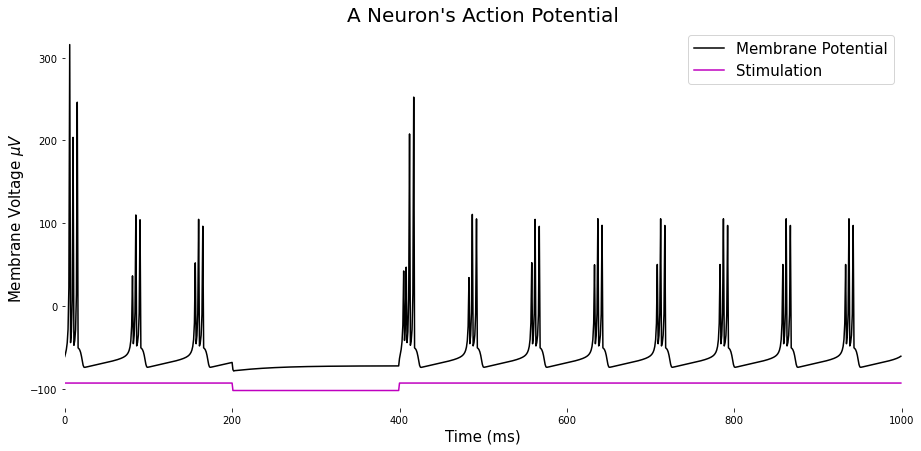

In [4]:
fig,ax = plt.subplots(1, figsize=(15,7))
plt.plot(memvolt, "k", label="Membrane Potential")
plt.plot(Iall-100, "m", label="Stimulation")
plt.legend(fontsize=15)
plt.box(False)
plt.xlim([0,simulation_time])
plt.xlabel("Time (ms)", fontsize = 15)
plt.ylabel("Membrane Voltage $\mu V$", fontsize=15)
plt.title("A Neuron's Action Potential", fontsize=20)
plt.show()

## A Circuit of 1000 Neurons

Although it is not the case in reality, in this model we will create an all-connected model where every neuron will be connected to every other neuron. Therefore we will have a 1000x1000 connectivity matrix.

In [5]:
# Excitatory Cells                   Inhibitory Cells
Ne = 800;                            Ni = 200
re = np.random.rand(Ne)**2;          ri = np.random.rand(Ni)
a = np.hstack((0.02*np.ones(Ne),     0.02+0.08*ri))
b = np.hstack((0.2*np.ones(Ne),      0.25-0.05*ri))
c = np.hstack((-65+15*re,            -65*np.ones(Ni)))
d = np.hstack((8-6*re,               2*np.ones(Ni)))

v = -65*np.ones(Ne +Ni)
u = b*v

# The S Matrix (Connectivity)
S = np.hstack((0.5*np.random.rand(Ne+Ni,Ne), - np.random.rand(Ne+Ni,Ni)))

In [6]:
S.shape

(1000, 1000)

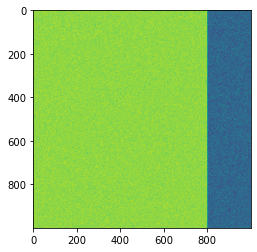

In [7]:
plt.imshow(S);

## Simulate the Neural Circuit

In [8]:
simulation_time = 5000 # 5 seconds
firings = np.array([ [],[] ])

for t in range(simulation_time):
    
    # Define Exogenous input
    I = np.hstack((5*np.random.randn(Ne), 2*np.random.randn(Ni)))
    
    # Check for action potentials
    fired = np.where(v>30)[0]
    
    # Store the spike indices and time (firing vaiable)
    tmp = np.stack((np.tile(t, len(fired)),fired))
    firings = np.concatenate((firings,tmp),axis=1)
    
    # Update membrane vaiables for neurons that spiked
    v[fired] = c[fired]
    u[fired] = u[fired] + d[fired]
    
    # Update the input to include spiking activity
    I = I + np.sum(S[:,fired],axis=1)
    
    # Update membrane potential for all neurons
    v += 0.04*v**2 + 5*v + 140 - u + I
    u += a*(b*v-u)

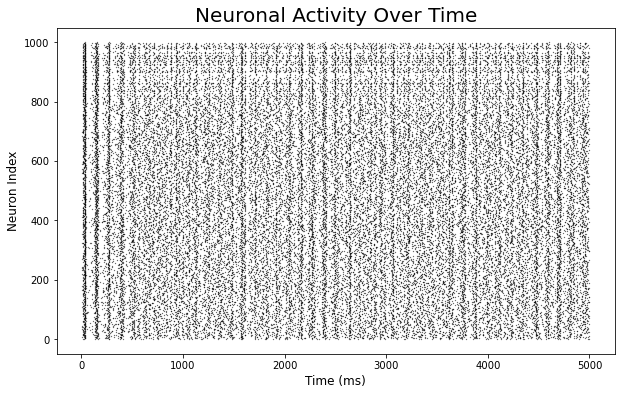

In [9]:
fig = plt.subplots(1, figsize=(10,6))
plt.plot(firings[0,:], firings[1,:], "k.", markersize=0.5)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Neuron Index", fontsize=12)
plt.title("Neuronal Activity Over Time",fontsize=20)
plt.show()

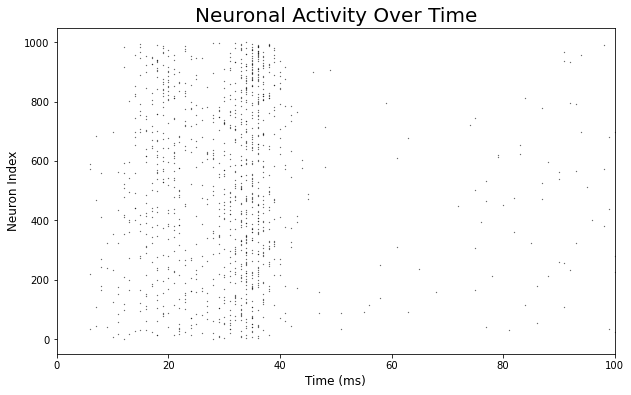

In [10]:
fig = plt.subplots(1, figsize=(10,6))
plt.plot(firings[0,:], firings[1,:], "k.", markersize=0.5)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Neuron Index", fontsize=12)
plt.title("Neuronal Activity Over Time",fontsize=20)
plt.xlim([0,100])
plt.show()

## Visualize Population Activity

We want to know the proportion of neurons that fired (emmited action potential) at a certian time point. This will give us a tim-domain plot of the proportion of neurons active at a particular time in time-series format which will be further processed with FT.

In [11]:
popact = np.zeros(simulation_time)
for t in range(simulation_time):
    popact[t] = 100*np.sum(firings[0,:] == t) / (Ne+Ni)

In [12]:
# Frequency Domain
popactX = np.abs(np.fft.fft(popact))**2
hz = np.linspace(0,1000/2, int(simulation_time/2+1))

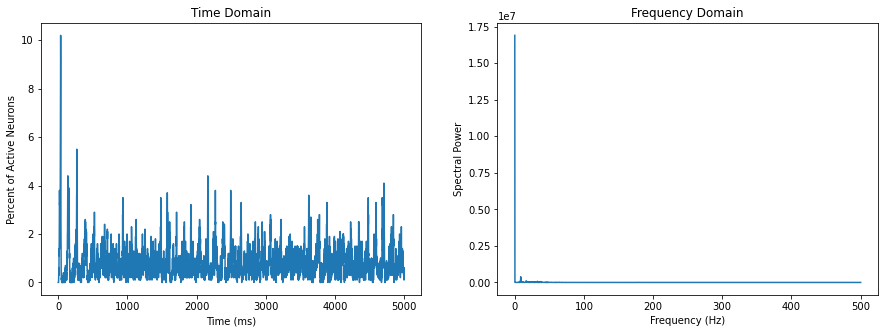

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(popact)
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Percent of Active Neurons")
ax[0].set_title("Time Domain")

ax[1].plot(hz, popactX[:len(hz)])
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Spectral Power")
ax[1].set_title("Frequency Domain")
plt.show()

In [14]:
# To deal with hte above problem, we subtract the mean from each data point
popactX = np.abs(np.fft.fft(popact - np.mean(popact)))**2
hz = np.linspace(0,1000/2, int(simulation_time/2+1))

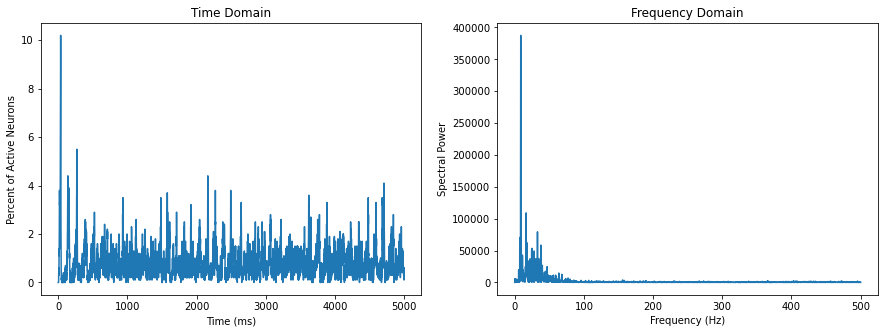

In [15]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(popact)
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Percent of Active Neurons")
ax[0].set_title("Time Domain")

ax[1].plot(hz, popactX[:len(hz)])
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Spectral Power")
ax[1].set_title("Frequency Domain")
plt.show()

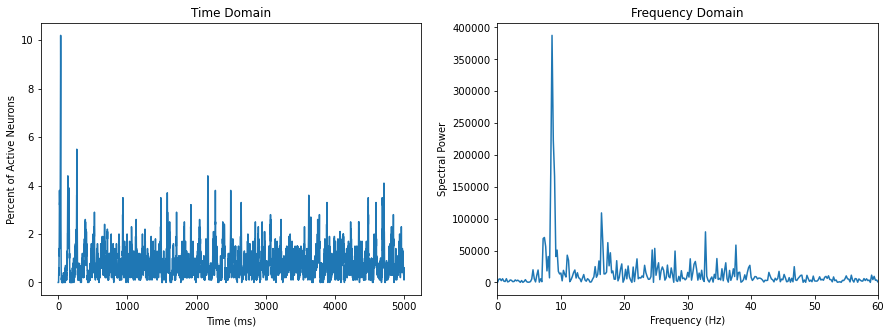

In [16]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(popact)
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Percent of Active Neurons")
ax[0].set_title("Time Domain")

ax[1].plot(hz, popactX[:len(hz)])
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Spectral Power")
ax[1].set_title("Frequency Domain")
ax[1].set_xlim([0,60])
plt.show()

## Run Some Experiments

In [17]:
def simCircuit(I):
    """
    I is a vector
    """
    firings = np.array([ [],[] ])
    
    # Reset v and u
    v = -65*np.ones(Ne+Ni)
    u = b*v

    for t in range(len(I)):

        # Define Exogenous input
        stim = np.hstack((4*np.random.randn(Ne), np.random.randn(Ni)))
        stim = stim + I[t]

        # Check for action potentials
        fired = np.where(v>30)[0]

        # Store the spike indices and time (firing vaiable)
        tmp = np.stack((np.tile(t, len(fired)),fired))
        firings = np.concatenate((firings,tmp),axis=1)

        # Update membrane vaiables for neurons that spiked
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        # Update the input to include spiking activity
        stim = stim + np.sum(S[:,fired],axis=1)

        # Update membrane potential for all neurons
        v += 0.04*v**2 + 5*v + 140 - u + stim
        u += a*(b*v-u)
    
    return firings

In [18]:
def plotPopActivity(firings):
    
    npnts = int(np.max(firings[0,:])) +1
    
    popact = np.zeros(npnts)
    for t in range(npnts):
        popact[t] = 100*np.sum(firings[0,:] == t) / (Ne+Ni)
    
    popactX = np.abs(np.fft.fft(popact - np.mean(popact)))**2
    hz = np.linspace(0,1000/2, int(npnts/2+1))
    
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    ax[0].plot(firings[0,:], firings[1,:], "k.", markersize=0.5)
    ax[0].plot(I*50 + 100, "m", linewidth=2)
    ax[0].set_xlabel("Time (ms)", fontsize=12)
    ax[0].set_ylabel("Neuron Index", fontsize=12)
    ax[0].set_title("All Neuron Firings",fontsize=20)
    
    ax[1].plot(popact)
    ax[1].set_xlabel("Time (ms)")
    ax[1].set_ylabel("Percent of Active Neurons")
    ax[1].set_title("Time Domain")

    ax[2].plot(hz, popactX[:len(hz)])
    ax[2].set_xlabel("Frequency (Hz)")
    ax[2].set_ylabel("Spectral Power")
    ax[2].set_title("Frequency Domain")
    ax[2].set_xlim([0,60])
    plt.show()

In [19]:
# Experiment 1
I = np.ones(1200)
I[400:601] = -2

# Run the simulation
networkspikes = simCircuit(I)
networkspikes

array([[   5.,    6.,    6., ..., 1199., 1199., 1199.],
       [ 672.,   61.,  373., ...,  873.,  907.,  982.]])

In [20]:
networkspikes.shape

(2, 13949)

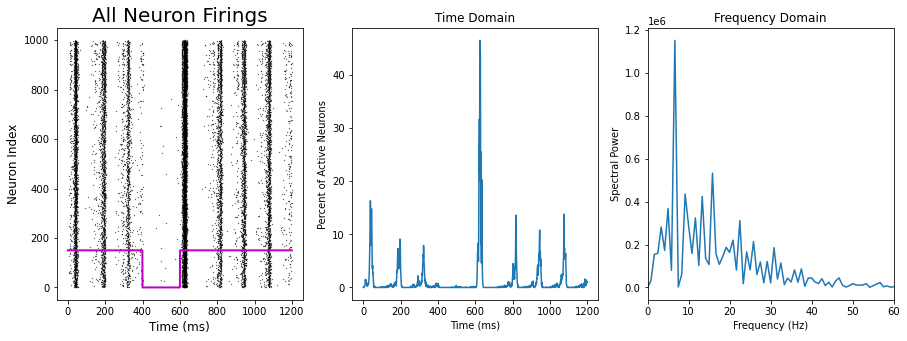

In [21]:
plotPopActivity(networkspikes)

/var/folders/wh/83kd80754n51v2m2g0jx2wynk10f9n/T/ipykernel_10658/3270650843.py:32: RuntimeWarning: overflow encountered in square
  v += 0.04*v**2 + 5*v + 140 - u + stim
/var/folders/wh/83kd80754n51v2m2g0jx2wynk10f9n/T/ipykernel_10658/3270650843.py:33: RuntimeWarning: invalid value encountered in add
  u += a*(b*v-u)
/var/folders/wh/83kd80754n51v2m2g0jx2wynk10f9n/T/ipykernel_10658/3270650843.py:32: RuntimeWarning: invalid value encountered in add
  v += 0.04*v**2 + 5*v + 140 - u + stim


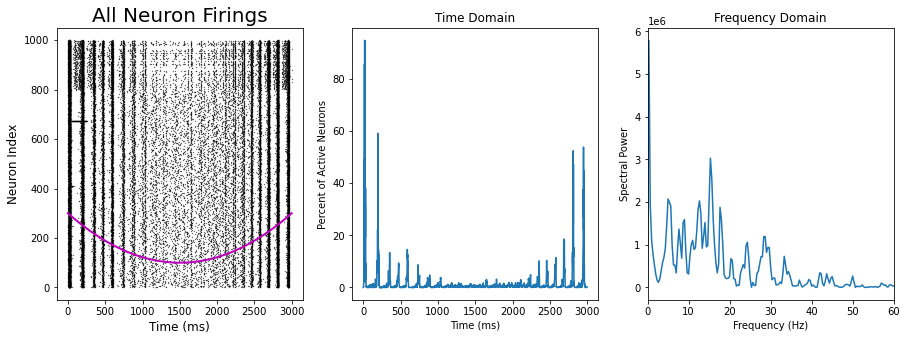

In [22]:
# Experiment 2
I = np.linspace(-2,2,3000)**2
networkspikes = simCircuit(I)
plotPopActivity(networkspikes)

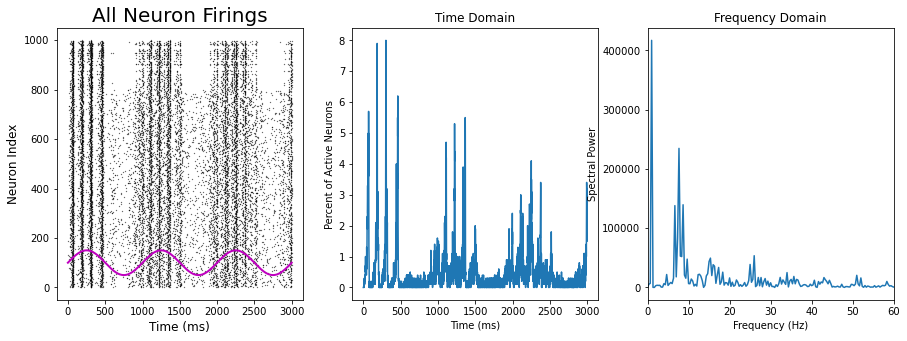

In [23]:
# Experiment 3
# Experiment 2
I = np.sin(np.linspace(0,6*np.pi, 3000))
networkspikes = simCircuit(I)
plotPopActivity(networkspikes)

## Separate Excitatory and Inhibitory Signals

In [24]:
def plotPopActivity_EI(firings):
    
    npnts = int(np.max(firings[0,:])) +1
    
    popact = np.zeros((2,npnts))
    for t in range(npnts):
        popact[0,t] = 100*np.sum(firings[0,firings[1,:]<Ne] == t) /Ne
        popact[1,t] = 100*np.sum(firings[0,firings[1,:]>= Ne] == t) /Ni
    
    popactXE = np.abs(np.fft.fft(popact[0,:] - np.mean(popact[0,:])))**2
    popactXI = np.abs(np.fft.fft(popact[1,:] - np.mean(popact[1,:])))**2
    hz = np.linspace(0,1000/2, int(npnts/2+1))
    
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    ax[0].plot(firings[0,firings[1,:]<Ne], firings[1,firings[1,:]<Ne], "g.", markersize=0.5)
    ax[0].plot(firings[0,firings[1,:]>=Ne], firings[1,firings[1,:]>=Ne], "r.", markersize=0.5)
    ax[0].plot(I*50 + 100, "m", linewidth=2)
    ax[0].set_xlabel("Time (ms)", fontsize=12)
    ax[0].set_ylabel("Neuron Index", fontsize=12)
    ax[0].set_title("All Neuron Firings",fontsize=20)
    
    ax[1].plot(popact[1,:],"r",label="I Cells")
    ax[1].plot(popact[0,:],"g",label="E Cells")
    ax[1].legend()
    ax[1].set_xlabel("Time (ms)")
    ax[1].set_ylabel("Percent of Active Neurons")
    ax[1].set_title("Time Domain")

    ax[2].plot(hz, popactXI[:len(hz)], "r")
    ax[2].plot(hz, popactXE[:len(hz)], "g")
    ax[2].set_xlabel("Frequency (Hz)")
    ax[2].set_ylabel("Spectral Power")
    ax[2].set_title("Frequency Domain")
    ax[2].set_xlim([0,60])
    plt.show()

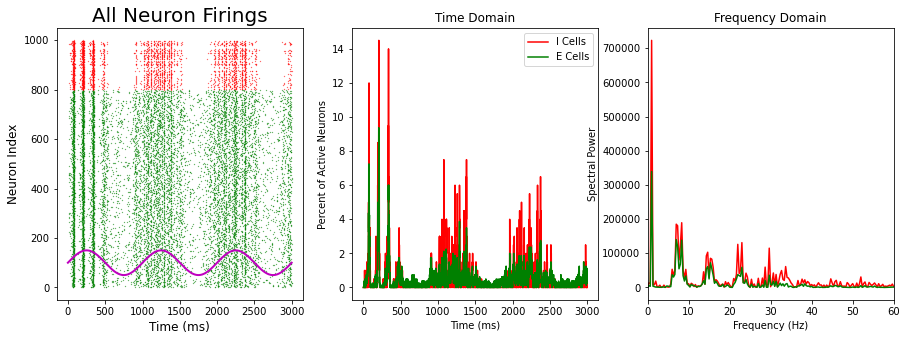

In [25]:
I = np.sin(np.linspace(0,6*np.pi, 3000))
networkspikes = simCircuit(I)
plotPopActivity_EI(networkspikes)

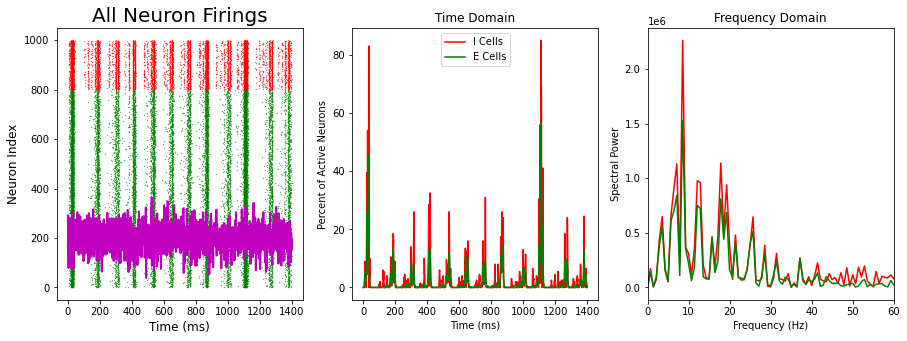

In [27]:
I = np.random.randn(1400) + 2
networkspikes = simCircuit(I)
plotPopActivity_EI(networkspikes)